# Multi-label classification -- instance weighting with logistic loss

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import check_grad

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from evaluate import avgPrecision, avgPrecisionK, printEvaluation
from datasets import create_dataset_yeast_train, create_dataset_yeast_test, yeast_nLabels
from datasets import create_dataset_scene_train, create_dataset_scene_test, scene_nLabels
from datasets import create_dataset_mediamill_train, create_dataset_mediamill_test, mm_nLabels

In [3]:
datasets = ['yeast', 'scene', 'mediamill']
num_labels = [yeast_nLabels, scene_nLabels, mm_nLabels]
create_dataset_train_funcs = [create_dataset_yeast_train, 
                              create_dataset_scene_train, 
                              create_dataset_mediamill_train]
create_dataset_test_funcs  = [create_dataset_yeast_test,
                              create_dataset_scene_test,
                              create_dataset_mediamill_test]

In [4]:
data_ix = 1

In [5]:
dataset_name = datasets[data_ix]
nLabels = num_labels[data_ix]
create_dataset_train = create_dataset_train_funcs[data_ix]
create_dataset_test  = create_dataset_test_funcs [data_ix]

In [6]:
SEED = 123456789

The sigmoid function.

In [7]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

## Instance weighting with logistic loss

Multi-label learning with p-norm push loss.

In [8]:
def obj_instance_weighting(w, X, Y, C):
    """
        Objective with L2 regularisation and instance weighting with logistic loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - C: regularisation constant, is consistent with scikit-learn C = 1 / (N * \lambda)
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    assert(C > 0)
    
    W = w.reshape(L, D)  # reshape weight matrix
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    nPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    nNegAll = L - nPosAll        # number of negative labels for each example, N by 1
    
    for k in range(nLabels):
        wk = W[k, :]
        Yk = Y[:, k]
        sPosVec = np.dot(X[Yk == 1, :], wk)      # Nk+ by 1
        sNegVec = np.dot(X[Yk == 0, :], wk)      # NK- by 1
        nPosVec = nPosAll[Yk == 1]               # Nk+ by 1
        nNegVec = nNegAll[Yk == 0]               # NK- by 1
        
        lossPos = np.divide(np.log1p(np.exp(-sPosVec)), nPosVec)  # NK+ by 1
        lossNeg = np.divide(np.log1p(np.exp(sNegVec)), nNegVec)  # NK- by 1
        
        J += np.sum(lossPos) + np.sum(lossNeg)
        
        GradPos = -X[Yk == 1, :] * (1 / np.multiply(nPosVec, 1 + np.exp( sPosVec)))[:, None]
        GradNeg =  X[Yk == 0, :] * (1 / np.multiply(nNegVec, 1 + np.exp(-sNegVec)))[:, None]
        
        G[k, :] = np.sum(GradPos, axis=0) + np.sum(GradNeg, axis=0)
                
    #J = 0.5 * C * np.dot(w, w) + J / N
    #G = C * W + G / N
    
    # be consistent with scikit-learn C = 1 / (N * \lambda)
    J = 0.5 * np.dot(w, w) + C * J
    G = W + C * G
    
    return (J, G.ravel())

Check gradient

In [9]:
X_train, Y_train = create_dataset_train()
X_test,  Y_test  = create_dataset_test()

In [10]:
%%script false
#C = 1  # if C is lambda
C = 1 / X_train.shape[0]
w0 = np.random.rand(nFeatures * nLabels)
check_grad(lambda w: obj_instance_weighting(w, X_train, Y_train, C)[0], \
           lambda w: obj_instance_weighting(w, X_train, Y_train, C)[1], w0)

In [11]:
class MLC_instanceweight(BaseEstimator):
    """All methods are necessary for a scikit-learn estimator"""
    
    def __init__(self, C=1):
        """Initialisation"""
        
        assert C > 0
        self.C = C
        self.trained = False
        
    def fit(self, X_train, Y_train):
        """Model fitting by optimising the objective"""
        
        opt_method = 'BFGS' #'Newton-CG'
        options = {'disp': True}
        if options['disp']: 
            print('\nC: %g' % self.C)
            
        D = X_train.shape[1]
        L = Y_train.shape[1]
        w0 = np.random.rand(L * D)  # initial guess
        opt = minimize(obj_instance_weighting, w0, args=(X_train, Y_train, self.C), \
                       method=opt_method, jac=True, options=options)
        if opt.success is True:
            self.w = opt.x
            self.trained = True
        else:
            sys.stderr.write('Optimisation failed')
            self.trained = False
    
            
    def decision_function(self, X_test):
        """Make predictions (score is real number)"""
        
        assert self.trained is True, "Can't make prediction before training"
        D = X_test.shape[1]
        return np.dot(X_test, self.w.reshape(-1, D).T)
        
    
    def predict(self, X_test):
        """Make predictions (score is boolean)"""
        
        preds = self.decision_function(X_test)
        return (preds > 0)
    
    
    def score(self, X, Y):
        """Compute scoring metric"""
        
        allPreds = self.decision_function(X)
        return avgPrecisionK(Y, allPreds)
    
    # inherit from BaseEstimator instead of re-implement
    #
    #def get_params(self, deep = True):
    #def set_params(self, **params):

In [12]:
parameters = [{'C': [10**(e) for e in range(-6,1)]}]

clf = GridSearchCV(MLC_instanceweight(), parameters, cv=5)
clf.fit(X_train, Y_train)

print("\nBest parameters set found on development set:")
print(clf.best_params_)


C: 1e-06
Optimization terminated successfully.
         Current function value: 0.001342
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 1e-06
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 1e-05
Optimization terminated successfully.
         Current function value: 0.013388
         Iterat

/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
         Current function value: 470.871821
         Iterations: 77
         Function evaluations: 99
         Gradient evaluations: 99

C: 1


/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
         Current function value: 573.412984
         Iterations: 71
         Function evaluations: 99
         Gradient evaluations: 99

C: 1


/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Optimization terminated successfully.
         Current function value: 537.161317
         Iterations: 72
         Function evaluations: 88
         Gradient evaluations: 88

C: 1


/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
         Current function value: 489.165844
         Iterations: 76
         Function evaluations: 103
         Gradient evaluations: 100

C: 1


/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/home/dawei/apps/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
         Current function value: 462.235371
         Iterations: 69
         Function evaluations: 93
         Gradient evaluations: 93

C: 1
Optimization terminated successfully.
         Current function value: 697.216399
         Iterations: 89
         Function evaluations: 104
         Gradient evaluations: 104

Best parameters set found on development set:
{'C': 1}


In [13]:
for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], \
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.017 (+/-0.036) for {'C': 1e-06}
0.018 (+/-0.036) for {'C': 1e-05}
0.020 (+/-0.039) for {'C': 0.0001}
0.033 (+/-0.043) for {'C': 0.001}
0.136 (+/-0.127) for {'C': 0.01}
0.205 (+/-0.243) for {'C': 0.1}
0.262 (+/-0.344) for {'C': 1}


In [14]:
preds_train = clf.decision_function(X_train)
preds_test  = clf.decision_function(X_test)

In [15]:
print('Training set:')
printEvaluation(Y_train, preds_train)
print()
print('Test set:')
printEvaluation(Y_test, preds_test)

Training set:
Average Precision@K: 0.8291, 0.011

Test set:
Average Precision@K: 0.7291, 0.013


## Result analysis

In [16]:
precisions_train = [avgPrecision(Y_train, preds_train, k) for k in range(1, nLabels+1)]
precisions_test  = [avgPrecision(Y_test,  preds_test,  k) for k in range(1, nLabels+1)]

In [17]:
precisionK_train = avgPrecisionK(Y_train, preds_train)
precisionK_test  = avgPrecisionK(Y_test,  preds_test)

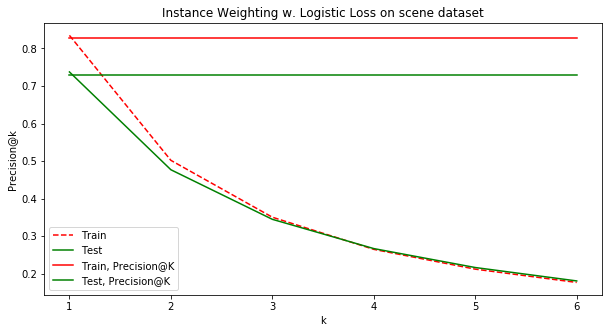

In [18]:
plt.figure(figsize=[10,5])
plt.plot(precisions_train, ls='--', c='r', label='Train')
plt.plot(precisions_test,  ls='-',  c='g', label='Test')
plt.plot([precisionK_train for k in range(nLabels)], ls='-', c='r', label='Train, Precision@K')
plt.plot([precisionK_test  for k in range(nLabels)], ls='-', c='g', label='Test, Precision@K')
plt.xticks(np.arange(nLabels), np.arange(1,nLabels+1))
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.legend(loc='best')
plt.title('Instance Weighting w. Logistic Loss on ' + dataset_name + ' dataset')
plt.savefig(dataset_name + '_iw.svg')